# Predicting ETH prices using NFT data

NFTs allow claiming ownership over digital art or data. Most of these non-fungible tokens are part of the Ethereum blockchain, but also a lot of them are bought using this cryptocurrency. Our goal is to determine whether we can predict the close price of ETH using parameters related to NFT. We were able to find a data set about NFT with different parameters, and merge them with our data frame of ETH Prices, in order to use them as predictors for the Linear Regression model.

### installing dependencies

In [ ]:
!pip install pmdarima

In [ ]:
!pip install quandl

In [2]:
import sys
!{sys.executable} -m pip install Prophet

Defaulting to user installation because normal site-packages is not writeable
  Using cached prophet-1.1.1-cp39-cp39-macosx_10_9_x86_64.whl (6.8 MB)
  Using cached holidays-0.16-py3-none-any.whl (184 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 935.8 kB/s eta 0:00:00 0:00:01
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached cmdstanpy-1.0.7-py3-none-any.whl (80 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 KB 1.3 MB/s eta 0:00:00
  Using cached PyMeeus-0.5.11-py3-none-any.whl
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
  Using cached korean_lunar_calendar-0.3.1-py3-none-any.whl (9.0 kB)
  Using cached ephem-4.1.3-cp39-cp39-macosx_10_9_x86_64.whl (1.4 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  NOTE: The current PAT

### Merging the 2 datasets

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import prophet
from pmdarima.arima import auto_arima
import quandl

import json
from utils import *

In [2]:
nft=pd.read_csv('resources/nft.csv')

In [3]:
nft

,Date,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
0,2017-06-22,0.000000e+00,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-23,1.020300e+03,19,8.0,0,19.0,53.70,1.020300e+03,19.0,8.0,0.0
2,2017-06-24,2.261140e+03,40,21.0,0,21.0,56.53,1.240840e+03,21.0,13.0,0.0
3,2017-06-25,2.778690e+03,53,28.0,0,13.0,52.43,5.175500e+02,13.0,7.0,0.0
4,2017-06-26,3.203320e+03,67,34.0,0,14.0,47.81,4.246300e+02,14.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1601,2021-11-08,1.008803e+10,10913146,NaN,6541355,14829.0,924.39,7.706698e+07,59264.0,NaN,44435.0
1602,2021-11-09,1.014001e+10,10964025,NaN,6573511,18723.0,924.84,5.197508e+07,50879.0,NaN,32156.0
1603,2021-11-10,1.019902e+10,11008847,NaN,6601205,17128.0,926.44,5.901034e+07,44822.0,NaN,27694.0
1604,2021-11-11,1.023456e+10,11022782,NaN,6609013,6127.0,928.49,3.554317e+07,13935.0,NaN,7808.0


In [4]:
eth=pd.read_csv('resources/coin_Ethereum.csv', parse_dates=True)

In [5]:
eth

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Ethereum,ETH,2015-08-08 23:59:59,2.798810,0.714725,2.793760,0.753325,6.741880e+05,4.548689e+07
1,2,Ethereum,ETH,2015-08-09 23:59:59,0.879810,0.629191,0.706136,0.701897,5.321700e+05,4.239957e+07
2,3,Ethereum,ETH,2015-08-10 23:59:59,0.729854,0.636546,0.713989,0.708448,4.052830e+05,4.281836e+07
3,4,Ethereum,ETH,2015-08-11 23:59:59,1.131410,0.663235,0.708087,1.067860,1.463100e+06,6.456929e+07
4,5,Ethereum,ETH,2015-08-12 23:59:59,1.289940,0.883608,1.058750,1.217440,2.150620e+06,7.364501e+07
...,...,...,...,...,...,...,...,...,...,...
2155,2156,Ethereum,ETH,2021-07-02 23:59:59,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11
2156,2157,Ethereum,ETH,2021-07-03 23:59:59,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11
2157,2158,Ethereum,ETH,2021-07-04 23:59:59,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11
2158,2159,Ethereum,ETH,2021-07-05 23:59:59,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11


Firstly, we have combined the two datasets the one contains ETH price data while the other one contains the NFT data.
To do that we had to use the same dates

In [6]:
nft_start_date=nft['Date'][0]
nft_end_date=nft['Date'][nft['Date'].count()-1]

In [7]:
print('nft start',nft_start_date,'nft end',nft_end_date)

nft start 2017-06-22 nft end 2021-11-12


In [8]:
eth_start_date=eth['Date'][0]
eth_end_date=eth['Date'][eth['Date'].count()-1]
print('eth start',eth_start_date,'eth end',eth_end_date)

eth start 2015-08-08 23:59:59 eth end 2021-07-06 23:59:59


In [9]:
eth=eth[eth['Date']>='2017-06-22 23:59:59']
nft=nft[nft['Date']<='2021-07-06']

In [10]:
eth

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
684,685,Ethereum,ETH,2017-06-22 23:59:59,342.027008,330.622009,337.733002,336.371002,9.257670e+08,3.118533e+10
685,686,Ethereum,ETH,2017-06-23 23:59:59,348.006012,334.989990,336.484985,341.739014,5.932070e+08,3.169191e+10
686,687,Ethereum,ETH,2017-06-24 23:59:59,343.621002,322.087006,341.625000,323.696014,6.735850e+08,3.002724e+10
687,688,Ethereum,ETH,2017-06-25 23:59:59,332.791992,284.645996,323.466003,303.247986,1.186880e+09,2.813841e+10
688,689,Ethereum,ETH,2017-06-26 23:59:59,311.458008,238.649002,302.954987,272.691986,2.081810e+09,2.530976e+10
...,...,...,...,...,...,...,...,...,...,...
2155,2156,Ethereum,ETH,2021-07-02 23:59:59,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11
2156,2157,Ethereum,ETH,2021-07-03 23:59:59,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11
2157,2158,Ethereum,ETH,2021-07-04 23:59:59,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11
2158,2159,Ethereum,ETH,2021-07-05 23:59:59,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11


In [11]:
eth['Date']=eth['Date'].str.extract('(.+)\s') #we had to remove the time part of the date as it was always 23:59:59 and the nft data doesn't have this

C:\Users\tniza\AppData\Local\Temp\ipykernel_45864\3755577454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth['Date']=eth['Date'].str.extract('(.+)\s') #we had to remove the time part of the date as it was always 23:59:59 and the nft data doesn't have this


In [12]:
eth.index=np.arange(0,1476)

In [13]:
eth

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,685,Ethereum,ETH,2017-06-22,342.027008,330.622009,337.733002,336.371002,9.257670e+08,3.118533e+10
1,686,Ethereum,ETH,2017-06-23,348.006012,334.989990,336.484985,341.739014,5.932070e+08,3.169191e+10
2,687,Ethereum,ETH,2017-06-24,343.621002,322.087006,341.625000,323.696014,6.735850e+08,3.002724e+10
3,688,Ethereum,ETH,2017-06-25,332.791992,284.645996,323.466003,303.247986,1.186880e+09,2.813841e+10
4,689,Ethereum,ETH,2017-06-26,311.458008,238.649002,302.954987,272.691986,2.081810e+09,2.530976e+10
...,...,...,...,...,...,...,...,...,...,...
1471,2156,Ethereum,ETH,2021-07-02,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11
1472,2157,Ethereum,ETH,2021-07-03,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11
1473,2158,Ethereum,ETH,2021-07-04,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11
1474,2159,Ethereum,ETH,2021-07-05,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11


In [14]:
i=0
while(eth['Date'].iloc[i]==nft['Date'].iloc[i]):
    i+=1
print(i)
position_of_missing_value=i

932


There was one missing value in the eth dataset so we had to find its position to remove the values for that date in the nft dataset because otherwise dates and data in two datasets would not match

In [15]:
print(eth['Date'].iloc[position_of_missing_value])
print(nft['Date'].iloc[position_of_missing_value])

2020-01-10
2020-01-09


In [16]:
print(eth['Date'].iloc[position_of_missing_value-1])
print(nft['Date'].iloc[position_of_missing_value-1])

2020-01-09
2020-01-09


In [17]:
print(eth['Date'].iloc[position_of_missing_value+1])
print(nft['Date'].iloc[position_of_missing_value+1])

2020-01-11
2020-01-10


In [18]:
nft=nft.drop(position_of_missing_value)

In [19]:
nft

,Date,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
0,2017-06-22,0.000000e+00,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-23,1.020300e+03,19,8.0,0,19.0,53.70,1020.30,19.0,8.0,0.0
2,2017-06-24,2.261140e+03,40,21.0,0,21.0,56.53,1240.84,21.0,13.0,0.0
3,2017-06-25,2.778690e+03,53,28.0,0,13.0,52.43,517.55,13.0,7.0,0.0
4,2017-06-26,3.203320e+03,67,34.0,0,14.0,47.81,424.63,14.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1472,2021-07-02,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
1473,2021-07-03,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
1474,2021-07-04,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0
1475,2021-07-05,1.481467e+09,6337518,353709.0,4069971,5357.0,233.76,5999974.94,9717.0,480.0,4360.0


In [20]:
nft.index=np.arange(0,1476)

In [21]:
nft

,Date,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
0,2017-06-22,0.000000e+00,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-23,1.020300e+03,19,8.0,0,19.0,53.70,1020.30,19.0,8.0,0.0
2,2017-06-24,2.261140e+03,40,21.0,0,21.0,56.53,1240.84,21.0,13.0,0.0
3,2017-06-25,2.778690e+03,53,28.0,0,13.0,52.43,517.55,13.0,7.0,0.0
4,2017-06-26,3.203320e+03,67,34.0,0,14.0,47.81,424.63,14.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1471,2021-07-02,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
1472,2021-07-03,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
1473,2021-07-04,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0
1474,2021-07-05,1.481467e+09,6337518,353709.0,4069971,5357.0,233.76,5999974.94,9717.0,480.0,4360.0


In [22]:
eth_nft=pd.merge(eth,nft)

In [23]:
#parsing dates and setting index as time
eth_nft['Date'] = pd.to_datetime(eth_nft['Date'])
eth_nft.set_index('Date', inplace=True)
eth_nft

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
Date,,,,,,,,,,,,,,,,,,,
2017-06-22,685,Ethereum,ETH,342.027008,330.622009,337.733002,336.371002,9.257670e+08,3.118533e+10,0.000000e+00,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-23,686,Ethereum,ETH,348.006012,334.989990,336.484985,341.739014,5.932070e+08,3.169191e+10,1.020300e+03,19,8.0,0,19.0,53.70,1020.30,19.0,8.0,0.0
2017-06-24,687,Ethereum,ETH,343.621002,322.087006,341.625000,323.696014,6.735850e+08,3.002724e+10,2.261140e+03,40,21.0,0,21.0,56.53,1240.84,21.0,13.0,0.0
2017-06-25,688,Ethereum,ETH,332.791992,284.645996,323.466003,303.247986,1.186880e+09,2.813841e+10,2.778690e+03,53,28.0,0,13.0,52.43,517.55,13.0,7.0,0.0
2017-06-26,689,Ethereum,ETH,311.458008,238.649002,302.954987,272.691986,2.081810e+09,2.530976e+10,3.203320e+03,67,34.0,0,14.0,47.81,424.63,14.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,2156,Ethereum,ETH,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
2021-07-03,2157,Ethereum,ETH,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
2021-07-04,2158,Ethereum,ETH,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0


### Analysing 2 merged datasets

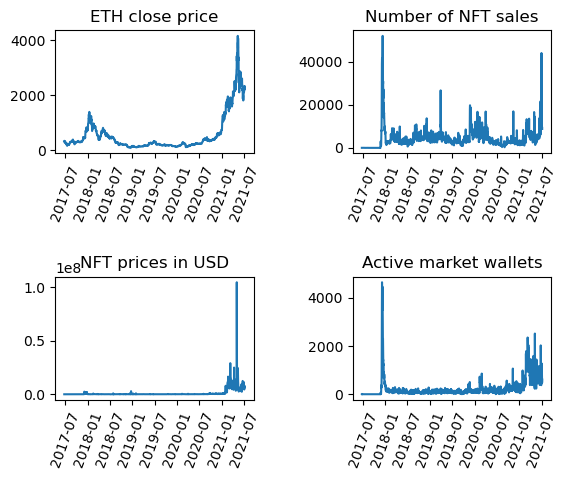

In [24]:
plt.subplot(2, 2, 1)
plt.plot(eth_nft.index, eth_nft['Close'])
plt.xticks(rotation=70)
plt.title('ETH close price')

plt.subplot(2, 2, 2)
plt.plot(eth_nft.index, eth_nft['Number_of_Sales'])
plt.xticks(rotation=70)
plt.title('Number of NFT sales')

plt.subplot(2, 2, 3)
plt.plot(eth_nft.index, eth_nft['Sales_USD'])
plt.xticks(rotation=70)
plt.title('NFT prices in USD')

plt.subplot(2, 2, 4)
plt.plot(eth_nft.index, eth_nft['Active_Market_Wallets'])
plt.xticks(rotation=70)
plt.title('Active market wallets')

plt.subplots_adjust(hspace=1, wspace=0.5)

From these graphs we can see that the first spike in the ETH Close price,Active market wallets, and Number of NFT sales appear at the similar time which means that they might be correlated

ETH close price also rose at the sime time the number of Ative market wallets rose and when there was a spike i NFT prices in USD and Number of NFT sales

In [25]:
parameters=['High','Low','Open','Close','Volume','Marketcap','Sales_USD_cumsum','Number_of_Sales_cumsum','Active_Market_Wallets_cumsum','Primary_Sales_cumsum','Secondary_Sales_cumsum','AverageUSD_cum','Sales_USD','Number_of_Sales','Active_Market_Wallets','Primary_Sales']

In [26]:
parameters.remove('Close')

In [27]:
#resetting data frame without date parsing and default index
eth_nft=pd.merge(eth,nft)
eth_nft=eth_nft.dropna()
eth_nft

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
1,686,Ethereum,ETH,2017-06-23,348.006012,334.989990,336.484985,341.739014,5.932070e+08,3.169191e+10,1.020300e+03,19,8.0,0,19.0,53.70,1020.30,19.0,8.0,0.0
2,687,Ethereum,ETH,2017-06-24,343.621002,322.087006,341.625000,323.696014,6.735850e+08,3.002724e+10,2.261140e+03,40,21.0,0,21.0,56.53,1240.84,21.0,13.0,0.0
3,688,Ethereum,ETH,2017-06-25,332.791992,284.645996,323.466003,303.247986,1.186880e+09,2.813841e+10,2.778690e+03,53,28.0,0,13.0,52.43,517.55,13.0,7.0,0.0
4,689,Ethereum,ETH,2017-06-26,311.458008,238.649002,302.954987,272.691986,2.081810e+09,2.530976e+10,3.203320e+03,67,34.0,0,14.0,47.81,424.63,14.0,6.0,0.0
5,690,Ethereum,ETH,2017-06-27,293.088013,227.136993,272.691986,293.088013,1.973870e+09,2.721128e+10,5.296230e+03,100,44.0,0,33.0,52.96,2092.91,33.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2156,Ethereum,ETH,2021-07-02,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
1472,2157,Ethereum,ETH,2021-07-03,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
1473,2158,Ethereum,ETH,2021-07-04,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0
1474,2159,Ethereum,ETH,2021-07-05,2321.922836,2163.041394,2321.922836,2198.582464,2.010379e+10,2.562978e+11,1.481467e+09,6337518,353709.0,4069971,5357.0,233.76,5999974.94,9717.0,480.0,4360.0


In [28]:
correlation=eth_nft.corr()
eth_nft.corr().style.background_gradient(cmap='Blues', axis=0)

,SNo,High,Low,Open,Close,Volume,Marketcap,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
SNo,1.000000,0.440720,0.444798,0.441993,0.443847,0.774226,0.483262,0.597830,0.997040,0.947394,0.994254,0.148274,0.050477,0.356418,0.101280,0.286266,0.052421
High,0.440720,1.000000,0.996528,0.998654,0.998159,0.727580,0.996400,0.851590,0.422867,0.653980,0.391004,0.078763,0.681444,0.618406,0.140628,0.483829,0.160749
Low,0.444798,0.996528,1.000000,0.996465,0.998279,0.708881,0.996702,0.849384,0.426631,0.657147,0.394605,0.079250,0.677720,0.621615,0.143187,0.487002,0.164328
Open,0.441993,0.998654,0.996465,1.000000,0.996072,0.722474,0.994430,0.851954,0.424054,0.655374,0.392146,0.077989,0.681155,0.612493,0.140317,0.483865,0.160808
Close,0.443847,0.998159,0.998279,0.996072,1.000000,0.719621,0.998326,0.850208,0.425784,0.656314,0.393802,0.079545,0.679061,0.623991,0.142954,0.487798,0.163768
Volume,0.774226,0.727580,0.708881,0.722474,0.719621,1.000000,0.742507,0.681482,0.763808,0.810372,0.745578,0.100665,0.338029,0.477859,0.061474,0.364504,0.024435
Marketcap,0.483262,0.996400,0.996702,0.994430,0.998326,0.742507,1.000000,0.869025,0.464738,0.688978,0.434295,0.082248,0.680423,0.632351,0.143366,0.489375,0.162528
Sales_USD_cumsum,0.597830,0.851590,0.849384,0.851954,0.850208,0.681482,0.869025,1.000000,0.588723,0.796456,0.573436,0.153463,0.731371,0.558249,0.214336,0.439776,0.221879
Number_of_Sales_cumsum,0.997040,0.422867,0.426631,0.424054,0.425784,0.763808,0.464738,0.588723,1.000000,0.945000,0.996839,0.151509,0.030726,0.342361,0.101425,0.268499,0.050404
Active_Market_Wallets_cumsum,0.947394,0.653980,0.657147,0.655374,0.656314,0.810372,0.688978,0.796456,0.945000,1.000000,0.936584,0.162176,0.253539,0.469658,0.167306,0.377379,0.143863


In this correlation matrix we can see that there is a high correlation between the sum of NFT Sales in USD and the ETH prices (around 85%)

C:\Users\tniza\AppData\Local\Temp\ipykernel_45864\612029065.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(eth_nft.columns, rotation=65, fontsize=15)
C:\Users\tniza\AppData\Local\Temp\ipykernel_45864\612029065.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(eth_nft.columns, rotation=0, fontsize=15)


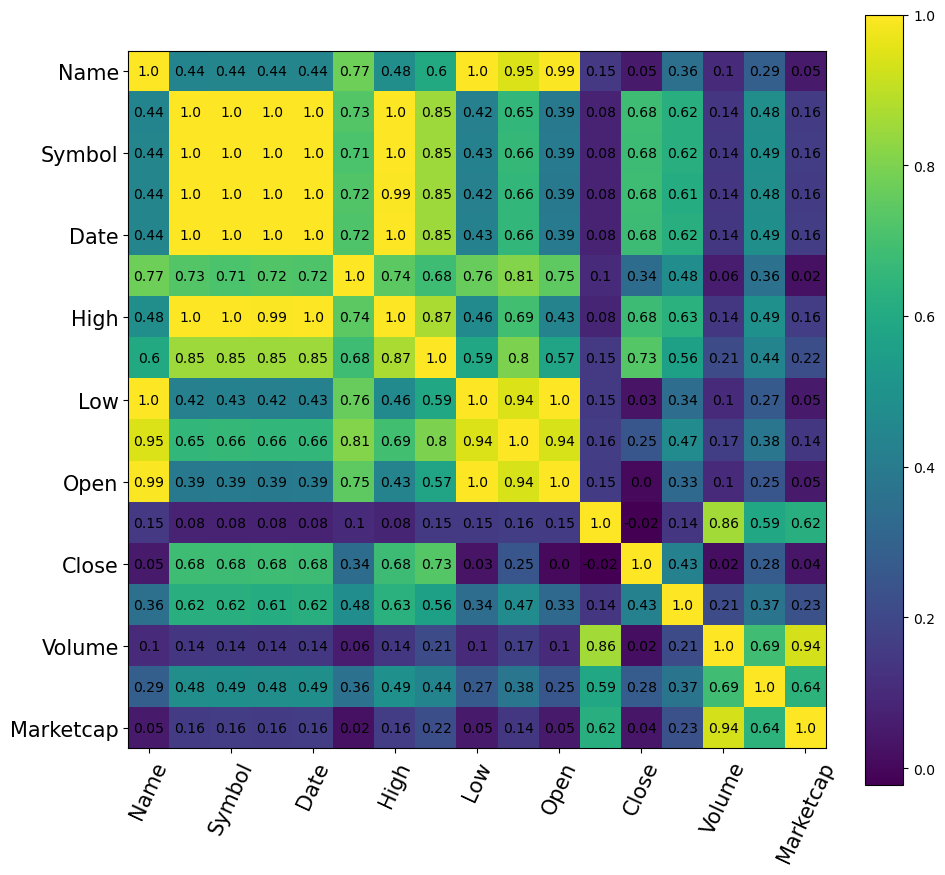

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(correlation, interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction = 0.05)

ax.set_xticklabels(eth_nft.columns, rotation=65, fontsize=15)
ax.set_yticklabels(eth_nft.columns, rotation=0, fontsize=15)


for i in range(len(eth_nft.columns)-3):
    for j in range(len(eth_nft.columns)-3):
        text = ax.text(j, i, round(correlation.to_numpy()[i, j], 2),
                       ha="center", va="center", color="black")

plt.show()

In [30]:
train=eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.8)]
y_train=train['Close']
test=eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.8,eth_nft['Date'].count())]
y_test=test['Close']

In [31]:
#parsing dates and setting index as time
test['Date'] = pd.to_datetime(test['Date'])
test.set_index('Date', inplace=True)
test

C:\Users\tniza\AppData\Local\Temp\ipykernel_45864\2255859578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = pd.to_datetime(test['Date'])


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,Sales_USD_cumsum,Number_of_Sales_cumsum,Active_Market_Wallets_cumsum,Primary_Sales_cumsum,Secondary_Sales_cumsum,AverageUSD_cum,Sales_USD,Number_of_Sales,Active_Market_Wallets,Primary_Sales
Date,,,,,,,,,,,,,,,,,,,
2020-09-15,1866,Ethereum,ETH,381.508293,363.606803,377.154029,364.839218,1.614058e+10,4.108764e+10,1.226192e+08,4875270,175767.0,3119480,790.0,25.15,478994.07,2957.0,109.0,2167.0
2020-09-16,1867,Ethereum,ETH,372.767424,356.682746,364.743986,365.812291,1.610761e+10,4.120215e+10,1.228148e+08,4877917,176012.0,3121392,735.0,25.18,195585.79,2647.0,245.0,1912.0
2020-09-17,1868,Ethereum,ETH,393.901600,364.795132,365.865770,389.019220,1.989953e+10,4.382135e+10,1.229943e+08,4879544,176154.0,3122767,252.0,25.21,179491.67,1627.0,142.0,1375.0
2020-09-18,1869,Ethereum,ETH,391.904133,376.964987,389.337495,384.364542,1.410836e+10,4.330219e+10,1.234016e+08,4882740,176594.0,3125048,915.0,25.27,407321.15,3196.0,440.0,2281.0
2020-09-19,1870,Ethereum,ETH,387.076345,378.724069,384.041667,385.544384,1.104951e+10,4.344036e+10,1.237001e+08,4884578,177160.0,3125962,924.0,25.32,298514.39,1838.0,566.0,914.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02,2156,Ethereum,ETH,2155.596496,2021.824808,2109.892677,2150.040364,3.179621e+10,2.505527e+11,1.463121e+09,6309511,351201.0,4057703,5636.0,231.89,7182851.23,11863.0,1277.0,6227.0
2021-07-03,2157,Ethereum,ETH,2237.567155,2117.590013,2150.835025,2226.114282,1.743336e+10,2.594475e+11,1.467575e+09,6318308,352362.0,4062004,4496.0,232.27,4454909.78,8797.0,1161.0,4301.0
2021-07-04,2158,Ethereum,ETH,2384.286857,2190.837703,2226.550382,2321.724112,1.878711e+10,2.706217e+11,1.475467e+09,6327801,353229.0,4065611,5886.0,233.17,7891255.32,9493.0,867.0,3607.0


### Predicting ETH price using NFT data and ETH data

Firstly, we have tried to predict the close price of ETH using all of the parameters in the eth_nft dataset

In [32]:
model=LinearRegression().fit(train[parameters],y_train)

In [33]:
y_pred = model.predict(train[parameters])
rss = sum((train['Close'] - y_pred)**2)

In [34]:
rss

28068.028853582764

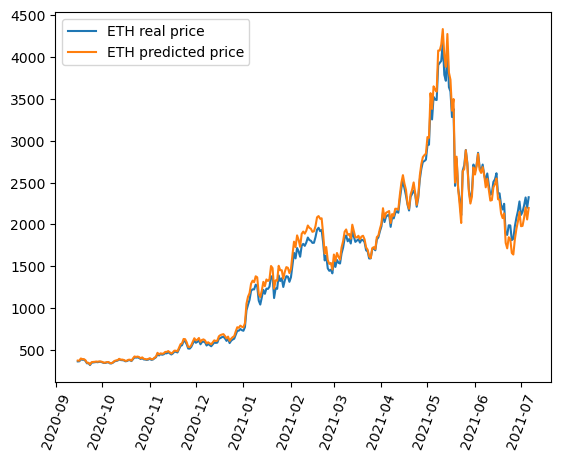

In [35]:
y_pred = model.predict(test[parameters])
rss = sum((y_test - y_pred)**2)
plt.plot(test.index,test['Close'], label='ETH real price')
plt.plot(test.index,y_pred, label='ETH predicted price')
plt.xticks(rotation=70)
plt.legend()

This has resulted in accurate predictions.
However we have used the parameters such as High,Low, and Open that are really close to the Close value becasue ETH prices do not fluctuate much during one day.

In [36]:
rss

1779863.9337920872

In [37]:
train_score=model.score(train[parameters],y_train)

In [38]:
train_score

0.9995192543419086

In [39]:
test_score=model.score(test[parameters],y_test)

In [40]:
test_score

0.9932703610378034

# Finetuning the model: Using Selection Algorithms

This is the same as the previous model we just used Backward and Forward selection to choose the best features

In [41]:
X = eth_nft.drop('Close', axis=1).drop(['Date', 'SNo', 'Name', 'Symbol'], axis=1)
Y = eth_nft['Close']

print('Backward:', validate_best_model(get_all_models(X, Y, n_iteration=len(X.columns), algorithm='backward', features=list(X.columns)), eth_nft, 'Close'))
print('Forward:', validate_best_model(get_all_models(X, Y, n_iteration=len(X.columns)), eth_nft, 'Close'))

Backward: (309290.55013033276, 0.9822968913658974, (LinearRegression(), 309290.55013033276, ['High', 'Low', 'Open', 'Marketcap', 'Primary_Sales_cumsum', 'AverageUSD_cum']))
Forward: (309290.55013032537, 0.9822968911228578, (LinearRegression(), 309290.55013032537, ['Marketcap', 'Primary_Sales_cumsum', 'AverageUSD_cum', 'High', 'Low', 'Open']))


Based on this the best features for predicting the ETH close price are 'High', 'Low', 'Open', 'Marketcap', 'Primary_Sales_cumsum', 'AverageUSD_cum'.
As we can see some of these features are from the NFT dataset but most of them are from the eth prices dataset.

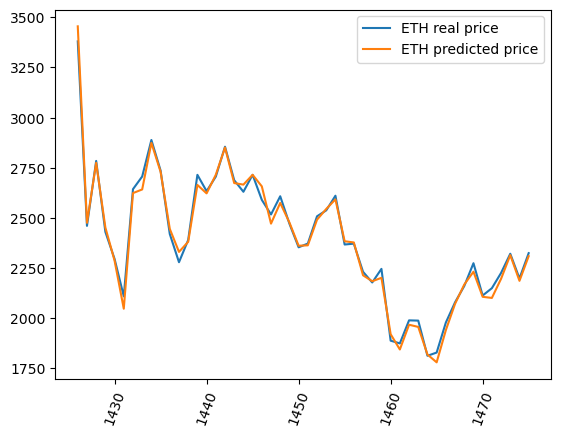

In [42]:
X = eth_nft.drop('Close', axis=1).drop(['SNo', 'Name', 'Symbol'], axis=1)
Y = eth_nft['Close']
Eth_model = LinearRegression().fit(X[['High', 'Low', 'Open', 'Marketcap', 'Primary_Sales_cumsum', 'AverageUSD_cum']], Y)
y_predict = Eth_model.predict(X[['High', 'Low', 'Open', 'Marketcap', 'Primary_Sales_cumsum', 'AverageUSD_cum']])

eth_nft['Prediction'] = y_predict

sensibility = 50
data = eth_nft.tail(sensibility)
plt.plot(data.index, data['Close'], label='ETH real price')
plt.plot(data.index, data['Prediction'], label='ETH predicted price')
plt.xticks(rotation=70)
plt.legend()
plt.show()

### Predicting the ETH price using only NFT data

Then we tried using just the NFT data to predict the Close price of ETH

In [43]:
train=eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.85)]
test=eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.85,eth_nft['Date'].count())]
nft_model=LinearRegression().fit(train[['Sales_USD_cumsum','Number_of_Sales_cumsum','Active_Market_Wallets_cumsum','Primary_Sales_cumsum','Secondary_Sales_cumsum','AverageUSD_cum','Sales_USD','Number_of_Sales','Active_Market_Wallets','Primary_Sales']],train['Close'])

In [44]:
train_score=nft_model.score(train[['Sales_USD_cumsum','Number_of_Sales_cumsum','Active_Market_Wallets_cumsum','Primary_Sales_cumsum','Secondary_Sales_cumsum','AverageUSD_cum','Sales_USD','Number_of_Sales','Active_Market_Wallets','Primary_Sales']],train['Close'])

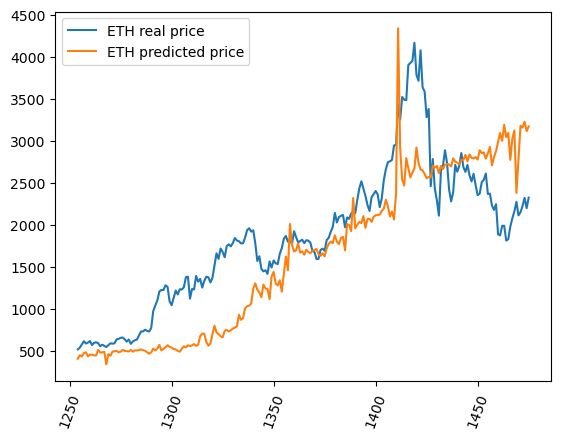

In [45]:
y_pred_nft = nft_model.predict(test[['Sales_USD_cumsum','Number_of_Sales_cumsum','Active_Market_Wallets_cumsum','Primary_Sales_cumsum','Secondary_Sales_cumsum','AverageUSD_cum','Sales_USD','Number_of_Sales','Active_Market_Wallets','Primary_Sales']])
y_test_nft=test['Close']
rss = sum((y_test_nft - y_pred_nft)**2)
plt.plot(test.index,y_test_nft, label='ETH real price')
plt.plot(test.index,y_pred_nft, label='ETH predicted price')
plt.xticks(rotation=70)
plt.legend()

As we can see from this even though this model is not perfect it still follows the trend of the ETH prices quite wellas shown in the following plot:
![](graph8.png)

In [46]:
test_score=nft_model.score(test[['Sales_USD_cumsum','Number_of_Sales_cumsum','Active_Market_Wallets_cumsum','Primary_Sales_cumsum','Secondary_Sales_cumsum','AverageUSD_cum','Sales_USD','Number_of_Sales','Active_Market_Wallets','Primary_Sales']],test['Close'])
test_score

0.500382960432016

This model has the accuracy of 50 % which is very good considering it is predicting the price of ETH using the NFT. Even though these two are related, prices of cryptocurrencies are unpredictable so this can be considered as the good score

### Time series prediction auto ARIMA

In [50]:
def time_series_prediction(df, train_percent):
    train=df.iloc[np.arange(0,df['Date'].count()*train_percent)]
    test=df.iloc[np.arange(df['Date'].count()*train_percent,df['Date'].count())]
    time_series_train=train['Close']
    time_series_test=test['Close']
    model = auto_arima(time_series_train, trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(time_series_train)
    forecast = model.predict(n_periods=len(time_series_test))
    return (np.sum((time_series_test-list(forecast.astype(float)))**2),list(forecast.astype(float)))

In [51]:
forecasts=list(time_series_prediction(eth_nft, i) for i in np.arange(0.5,1,0.05))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7053.831, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7049.856, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7050.741, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7050.716, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7047.860, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7050.262, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.599 seconds
Performing stepwise search to minimize aic


C:\Users\tniza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7692.599, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7688.996, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7689.819, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7689.794, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7687.038, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7689.061, Time=0.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.735 seconds
Performing stepwise search to minimize aic


C:\Users\tniza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8321.175, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8317.916, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8318.615, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8318.591, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8315.977, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8317.662, Time=0.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.183 seconds
Performing stepwise search to minimize aic


C:\Users\tniza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8933.653, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8930.689, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8931.296, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8931.270, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8928.716, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8930.204, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.827 seconds
Performing stepwise search to minimize aic


C:\Users\tniza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9572.870, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9569.076, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9569.829, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9569.811, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9567.120, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9569.473, Time=0.41 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.028 seconds
Performing stepwise search to minimize aic


C:\Users\tniza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10188.419, Time=2.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10184.872, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10185.635, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10185.618, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10182.893, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10185.059, Time=0.59 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.100 seconds
Performing stepwise search to minimize aic


C:\Users\tniza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10830.537, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10827.063, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10827.939, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10827.940, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10825.063, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10829.938, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.327 seconds
Performing stepwise search to minimize aic


C:\Users\tniza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11461.047, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11458.015, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11458.560, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11458.566, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11456.060, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11460.563, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.274 seconds
Performing stepwise search to minimize aic


C:\Users\tniza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(2,2,2)(0,0,0)[0]             : AIC=12638.908, Time=0.76 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=13538.501, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=13174.096, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=12635.260, Time=0.19 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=12637.227, Time=0.48 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=12637.225, Time=0.42 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=12637.252, Time=0.94 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=12636.248, Time=0.75 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 3.706 seconds


C:\Users\tniza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.49 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=14750.162, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=14336.254, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=14205.487, Time=0.11 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=14144.963, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=14078.406, Time=0.13 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=13968.570, Time=0.14 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.77 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.40 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=13970.568, Time=0.33 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 5.808 seconds


C:\Users\tniza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Here the function time_series_prediction is called to create a list that contains all prediction prices and and rss for each model. This is calculated for each model with different proportions of train and test data from 50:50 to 95:5 by each 5 percent (50:50,55:45...95:5)

In [52]:
#minimal=np.argsort(forecasts,key=lambda x:x[0])[0]
minimal=forecasts[0][0]
minimal_index=0
for i in range(len(forecasts)):
    if forecasts[i][0]<minimal:
        minimal=forecasts[i][0]
        minimal_index=i
minimal_percent=minimal_index*0.05+0.5
minimal,minimal_index,minimal_percent

(76818495.62998226, 8, 0.9)

Then the best model is determened by searching for the smallest rss.
In this case that is the 90:10 model

In [53]:
train=eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*minimal_percent)]
test=eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.9,eth_nft['Date'].count())]
time_series_train=train['Close']
time_series_test=test['Close']

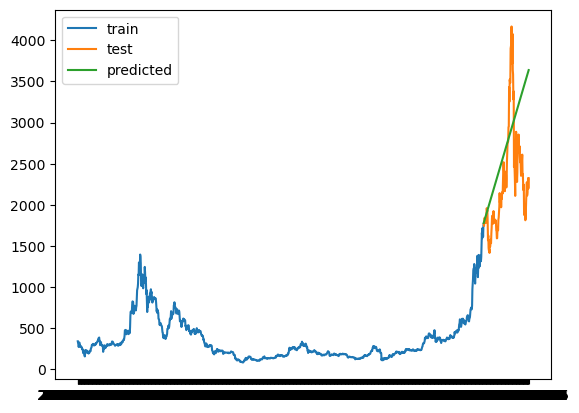

In [54]:
plt.plot(train['Date'],time_series_train,label='train')
plt.plot(test['Date'],time_series_test,label='test')
plt.plot(test['Date'],forecasts[minimal_index][1],label='predicted')
plt.legend()

In [55]:
#score
np.mean(abs(test['Close']-forecasts[minimal_index][1])/((test['Close']+forecasts[minimal_index][1])/2))

0.2290875063226905

### Time series analysis using prophet

Then we tried to predict future ETH prices using Facebook prophet

In [50]:
prophet_train= eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.9)]['Date']
prophet_train= prophet_train.rename('ds', inplace=True)
prophet_train= pd.DataFrame(prophet_train)
prophet_train['y']=eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.9)]['Close']
display(prophet_train)
prophet_test= eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.9,eth_nft['Date'].count())]['Date']
prophet_test= prophet_test.rename('ds', inplace=True)
prophet_test= pd.DataFrame(prophet_test)
prophet_test['y']=eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.9,eth_nft['Date'].count())]['Close']
display(prophet_test)

,ds,y
1,2017-06-23,341.739014
2,2017-06-24,323.696014
3,2017-06-25,303.247986
4,2017-06-26,272.691986
5,2017-06-27,293.088013
...,...,...
1324,2021-02-05,1718.650872
1325,2021-02-06,1677.846847
1326,2021-02-07,1614.227823
1327,2021-02-08,1746.616849


,ds,y
1328,2021-02-09,1768.035017
1329,2021-02-10,1744.243432
1330,2021-02-11,1783.797950
1331,2021-02-12,1843.532588
1332,2021-02-13,1814.109853
...,...,...
1471,2021-07-02,2150.040364
1472,2021-07-03,2226.114282
1473,2021-07-04,2321.724112
1474,2021-07-05,2198.582464


In [51]:
eth_nft_prophet = prophet.Prophet(changepoint_prior_scale=0.2)
eth_nft_prophet.fit(prophet_train)

15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:51 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
eth_nft_forecast = eth_nft_prophet.make_future_dataframe(periods=test['Date'].count(), freq='D')
# Make predictions
display(eth_nft_forecast)
eth_nft_forecast = eth_nft_prophet.predict(prophet_test)
eth_nft_forecast

,ds
0,2017-06-23
1,2017-06-24
2,2017-06-25
3,2017-06-26
4,2017-06-27
...,...
1545,2021-09-15
1546,2021-09-16
1547,2021-09-17
1548,2021-09-18


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-02-09,1511.052890,1446.916219,1582.099675,1511.052890,1511.052890,2.942118,2.942118,2.942118,1.532390,1.532390,1.532390,1.409727,1.409727,1.409727,0.0,0.0,0.0,1513.995008
1,2021-02-10,1517.799607,1459.787293,1598.098202,1517.799607,1517.799607,11.067752,11.067752,11.067752,-0.548584,-0.548584,-0.548584,11.616335,11.616335,11.616335,0.0,0.0,0.0,1528.867358
2,2021-02-11,1524.546324,1474.135759,1613.822225,1524.546324,1524.546324,18.664611,18.664611,18.664611,-3.390131,-3.390131,-3.390131,22.054742,22.054742,22.054742,0.0,0.0,0.0,1543.210934
3,2021-02-12,1531.293040,1495.351013,1625.565573,1531.293040,1531.293040,31.157971,31.157971,31.157971,-1.483754,-1.483754,-1.483754,32.641725,32.641725,32.641725,0.0,0.0,0.0,1562.451012
4,2021-02-13,1538.039757,1512.918281,1654.671676,1538.039757,1538.039757,44.839306,44.839306,44.839306,1.549570,1.549570,1.549570,43.289735,43.289735,43.289735,0.0,0.0,0.0,1582.879063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,2021-07-02,2475.833382,1913.195062,3608.120025,1683.707272,3360.394025,250.769910,250.769910,250.769910,-1.483754,-1.483754,-1.483754,252.253664,252.253664,252.253664,0.0,0.0,0.0,2726.603293
144,2021-07-03,2482.580099,1932.367666,3642.508530,1681.210334,3381.399836,248.095196,248.095196,248.095196,1.549570,1.549570,1.549570,246.545626,246.545626,246.545626,0.0,0.0,0.0,2730.675295
145,2021-07-04,2489.326816,1915.058336,3664.985215,1679.301402,3404.059518,242.283320,242.283320,242.283320,1.514980,1.514980,1.514980,240.768340,240.768340,240.768340,0.0,0.0,0.0,2731.610136
146,2021-07-05,2496.073532,1899.133601,3664.235902,1677.446320,3426.719199,235.760121,235.760121,235.760121,0.825528,0.825528,0.825528,234.934592,234.934592,234.934592,0.0,0.0,0.0,2731.833653


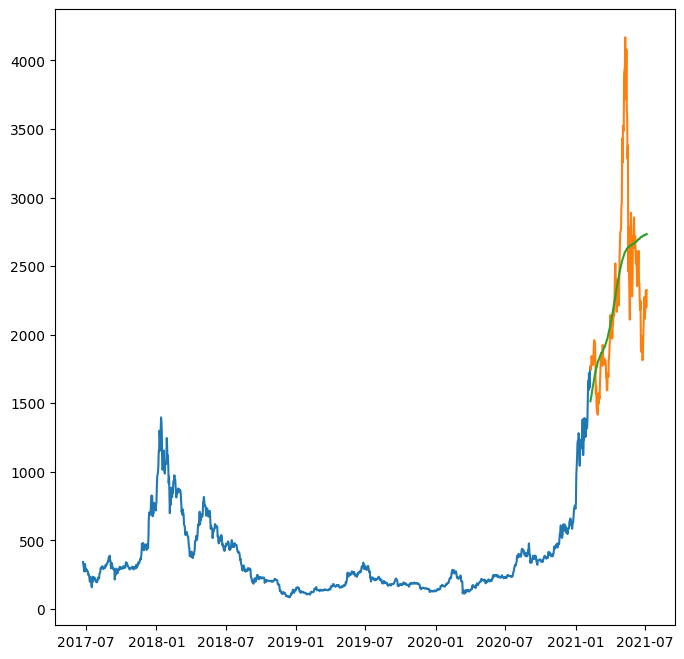

In [57]:

plt.figure(figsize=(8,8))
plt.plot(prophet_train['ds'].astype(np.datetime64),prophet_train['y'],label='train')
plt.plot(prophet_test['ds'].astype(np.datetime64),prophet_test['y'],label='test')
plt.plot(prophet_test['ds'].astype(np.datetime64),eth_nft_forecast['yhat'],label='predicted')

In [58]:
prophet_test.index=np.arange(prophet_test['y'].count())
np.sum((prophet_test['y']-eth_nft_forecast['yhat'])**2)

32025897.133043405

The results of the prediction by prophet are not perfect but the rss is lower than the rss of the ARIMA model (more than 2 times). This is how the prediction looks like when the training dataset is 90% and the test dataset is 10%. As we can see from this figure based on the increase of price before the data on which the test data starts it predicted that the prices will continue to drastically increase

In [60]:
prophet_train= eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.6)]['Date']
prophet_train= prophet_train.rename('ds', inplace=True)
prophet_train= pd.DataFrame(prophet_train)
prophet_train['y']=eth_nft.iloc[np.arange(0,eth_nft['Date'].count()*0.6)]['Close']
display(prophet_train)
prophet_test= eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.6,eth_nft['Date'].count())]['Date']
prophet_test= prophet_test.rename('ds', inplace=True)
prophet_test= pd.DataFrame(prophet_test)
prophet_test['y']=eth_nft.iloc[np.arange(eth_nft['Date'].count()*0.6,eth_nft['Date'].count())]['Close']
display(prophet_test)

,ds,y
1,2017-06-23,341.739014
2,2017-06-24,323.696014
3,2017-06-25,303.247986
4,2017-06-26,272.691986
5,2017-06-27,293.088013
...,...,...
881,2019-11-20,175.698343
882,2019-11-21,161.462726
883,2019-11-22,150.268171
884,2019-11-23,153.417792


,ds,y
886,2019-11-25,146.476536
887,2019-11-26,148.965066
888,2019-11-27,153.010552
889,2019-11-28,151.717574
890,2019-11-29,155.304146
...,...,...
1471,2021-07-02,2150.040364
1472,2021-07-03,2226.114282
1473,2021-07-04,2321.724112
1474,2021-07-05,2198.582464


In [61]:
eth_nft_prophet = prophet.Prophet(changepoint_prior_scale=0.2)
eth_nft_prophet.fit(prophet_train)

15:45:55 - cmdstanpy - INFO - Chain [1] start processing
15:45:55 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
eth_nft_forecast = eth_nft_prophet.make_future_dataframe(periods=test['Date'].count(), freq='D')
# Make predictions
display(eth_nft_forecast)
eth_nft_forecast = eth_nft_prophet.predict(prophet_test)
eth_nft_forecast

,ds
0,2017-06-23
1,2017-06-24
2,2017-06-25
3,2017-06-26
4,2017-06-27
...,...
1102,2020-06-29
1103,2020-06-30
1104,2020-07-01
1105,2020-07-02


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-11-25,338.180651,126.279447,248.272598,338.180651,338.180651,-151.235516,-151.235516,-151.235516,0.687877,0.687877,0.687877,-151.923393,-151.923393,-151.923393,0.0,0.0,0.0,186.945136
1,2019-11-26,339.241475,129.841420,250.321247,339.241475,339.241475,-149.566980,-149.566980,-149.566980,0.913407,0.913407,0.913407,-150.480387,-150.480387,-150.480387,0.0,0.0,0.0,189.674495
2,2019-11-27,340.302299,134.329043,249.833195,340.302299,340.302299,-149.952564,-149.952564,-149.952564,-1.205903,-1.205903,-1.205903,-148.746661,-148.746661,-148.746661,0.0,0.0,0.0,190.349736
3,2019-11-28,341.363123,134.535990,252.460414,341.363123,341.363123,-149.775828,-149.775828,-149.775828,-3.045899,-3.045899,-3.045899,-146.729928,-146.729928,-146.729928,0.0,0.0,0.0,191.587295
4,2019-11-29,342.423947,135.811429,253.542770,342.423947,342.423947,-145.927395,-145.927395,-145.927395,-1.487075,-1.487075,-1.487075,-144.440320,-144.440320,-144.440320,0.0,0.0,0.0,196.496552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,2021-07-02,958.762626,-5655.247118,7396.827826,-5759.304244,7331.926611,82.446363,82.446363,82.446363,-1.487075,-1.487075,-1.487075,83.933438,83.933438,83.933438,0.0,0.0,0.0,1041.208989
586,2021-07-03,959.823450,-5768.637811,7432.077371,-5780.541561,7343.879596,83.641416,83.641416,83.641416,2.436015,2.436015,2.436015,81.205402,81.205402,81.205402,0.0,0.0,0.0,1043.464866
587,2021-07-04,960.884274,-5774.166902,7484.502893,-5801.778878,7358.271905,80.112851,80.112851,80.112851,1.701578,1.701578,1.701578,78.411273,78.411273,78.411273,0.0,0.0,0.0,1040.997125
588,2021-07-05,961.945098,-5765.711154,7540.547476,-5823.016195,7386.354979,76.260986,76.260986,76.260986,0.687877,0.687877,0.687877,75.573108,75.573108,75.573108,0.0,0.0,0.0,1038.206083


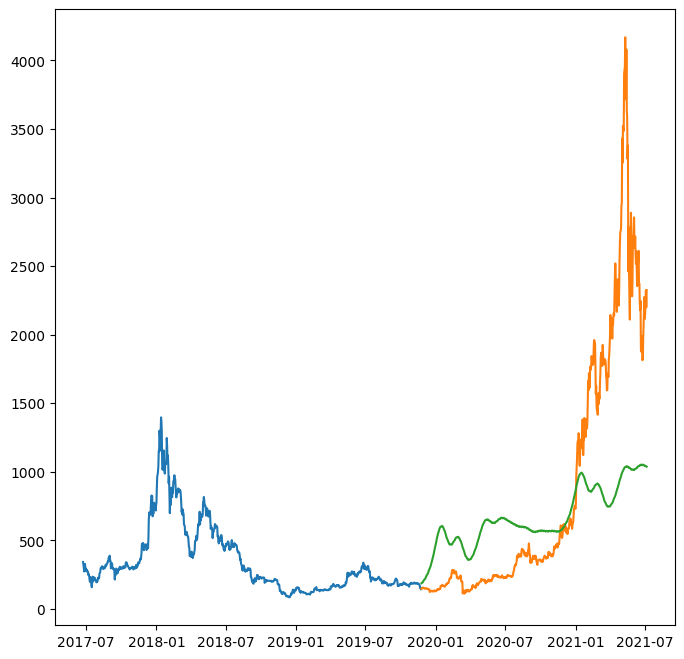

In [64]:
plt.figure(figsize=(8,8))

plt.plot(prophet_train['ds'].astype(np.datetime64),prophet_train['y'],label='train')
plt.plot(prophet_test['ds'].astype(np.datetime64),prophet_test['y'],label='test')
plt.plot(prophet_test['ds'].astype(np.datetime64),eth_nft_forecast['yhat'],label='predicted')

Here is how the prediction would look like if we use 60% of the datset to train the model and 40 % to test it. As there were no previous indications that the prices can be as high as they are at the end of this dataset it did't predict that the prices will increase that much. However, it did predict that the prices will increase

In [65]:
prophet_test.index=np.arange(prophet_test['y'].count())
np.sum((prophet_test['y']-eth_nft_forecast['yhat'])**2)

358006307.5266009

In [66]:
#score
np.mean(abs(prophet_test['y']-eth_nft_forecast['yhat'])/((abs(prophet_test['y'])+abs(eth_nft_forecast['yhat']))/2))

0.6770342711493613

#### Predicting the prices for the next year

Lastly, we wanted to see how will prophet predict prices for the year after the dataset we used ends

To do that we also downloaded the dataset from yahoo finances where we could choose to download the dataset that contains the dates from 7.7.2021. until 7.7.2022. 7.7.2021. is the last day in the dataset we used.


In [81]:
import datetime as dt
next_year_data=pd.read_csv('resources/ETH-USD-2.csv')
prophet_train_next_year= eth_nft['Date']

prophet_train_next_year=prophet_train_next_year.rename('ds')
prophet_train_next_year=pd.DataFrame(prophet_train_next_year)
prophet_train_next_year['y']=eth_nft['Close']

next_year_prophet = prophet.Prophet(changepoint_prior_scale=0.2)
next_year_prophet.fit(prophet_train_next_year)

next_year_forecast = next_year_prophet.make_future_dataframe(periods=next_year_data['Date'].count(), freq='D')
dates=next_year_data['Date']
dates=dates.rename('ds')
dates=pd.DataFrame(dates)
next_year_forecast  =next_year_prophet.predict(dates)
next_year_forecast 

16:35:53 - cmdstanpy - INFO - Chain [1] start processing
16:35:54 - cmdstanpy - INFO - Chain [1] done processing


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-07-07,2323.208496,2403.773438,2298.026855,2315.161865,2315.161865,22398345285
1,2021-07-08,2317.949219,2324.006836,2089.414307,2120.026367,2120.026367,23188123689
2,2021-07-09,2115.573975,2185.376221,2051.066650,2146.692383,2146.692383,23029574602
3,2021-07-10,2146.999756,2190.124023,2081.923584,2111.403564,2111.403564,17581542471
4,2021-07-11,2110.875732,2172.653320,2083.803711,2139.664795,2139.664795,14705386138
...,...,...,...,...,...,...,...
361,2022-07-03,1066.467407,1083.418945,1044.005615,1073.766968,1073.766968,8557248150
362,2022-07-04,1073.794312,1152.943848,1048.396362,1151.059082,1151.059082,13670889311
363,2022-07-05,1150.509766,1165.682739,1086.829956,1134.541016,1134.541016,16195518291
364,2022-07-06,1134.822266,1193.636719,1116.247559,1186.973999,1186.973999,15373536703


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-07-07,2303.221404,2263.433709,2614.580829,2303.221404,2303.221404,133.008896,133.008896,133.008896,1.263532,1.263532,1.263532,131.745364,131.745364,131.745364,0.0,0.0,0.0,2436.230300
1,2021-07-08,2308.777443,2257.408111,2608.082126,2308.777443,2308.777443,127.655729,127.655729,127.655729,-1.189739,-1.189739,-1.189739,128.845468,128.845468,128.845468,0.0,0.0,0.0,2436.433172
2,2021-07-09,2314.333482,2267.755589,2618.163314,2314.333482,2314.333482,122.951553,122.951553,122.951553,-3.466905,-3.466905,-3.466905,126.418459,126.418459,126.418459,0.0,0.0,0.0,2437.285035
3,2021-07-10,2319.889521,2260.569841,2614.541151,2319.889521,2319.889521,122.243067,122.243067,122.243067,-2.123530,-2.123530,-2.123530,124.366596,124.366596,124.366596,0.0,0.0,0.0,2442.132588
4,2021-07-11,2325.445560,2263.042124,2623.832978,2325.445560,2325.445560,122.018508,122.018508,122.018508,-0.566070,-0.566070,-0.566070,122.584577,122.584577,122.584577,0.0,0.0,0.0,2447.464068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2022-07-03,4308.951497,676.145184,8064.544331,484.194664,7835.785669,150.553921,150.553921,150.553921,-0.566070,-0.566070,-0.566070,151.119991,151.119991,151.119991,0.0,0.0,0.0,4459.505418
362,2022-07-04,4314.507536,586.562212,7954.431515,469.650559,7859.360584,147.149890,147.149890,147.149890,1.747455,1.747455,1.747455,145.402436,145.402436,145.402436,0.0,0.0,0.0,4461.657426
363,2022-07-05,4320.063575,671.135800,8071.476854,455.752863,7885.953853,144.766460,144.766460,144.766460,4.335258,4.335258,4.335258,140.431202,140.431202,140.431202,0.0,0.0,0.0,4464.830034
364,2022-07-06,4325.619614,640.111319,8059.645367,443.250475,7905.349975,137.430786,137.430786,137.430786,1.263532,1.263532,1.263532,136.167255,136.167255,136.167255,0.0,0.0,0.0,4463.050400


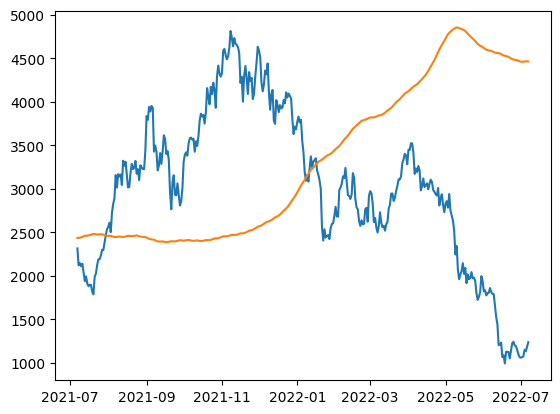

In [84]:
plt.plot(next_year_data['Date'].astype(np.datetime64),next_year_data['Close'])
plt.plot(next_year_data['Date'].astype(np.datetime64),next_year_forecast['yhat'])

Even though prophet was not able to predict future prices for the whole next year it is still interesting to see how this model thought the prices would look like.

As prophet uses a factor that takes into consideration how much holidays influence the price we can see that prophet made a prediction that prices wil star to rise during the holidays in December and January